##  Реализация метода L-BFGS для решения логистической регрессии 
### Дарья Дятлова, 1 курс МОиАД ВШЭ¶

In [3]:
import numpy as np
import random 
import scipy
from scipy.special import expit
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import functools
import time
from collections import deque
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

#### Заведем класс Helper с методами для рассчета времени работы функций и количиства вызовов оракла:

In [4]:
class Helper:
    counter = defaultdict(int)
    timer = {}
    data = {}

    @classmethod
    def timer_start(cls, label: str):
        cls.timer[label] = time.time()

    @classmethod
    def timer_stop(cls, label: str):
        if not cls.timer.get(label):
            print("Error - no label found")
            return

        cls.timer[label] = time.time() - cls.timer[label]
        return cls.timer[label]

    @classmethod
    def counter_add(cls, label: str):
        cls.counter[label] += 1

    @classmethod
    def counter_set(cls, label: str, value: int):
        cls.counter[label] = value

    @classmethod
    def reset(cls):
        cls.counter = defaultdict(int)
        cls.timer = {}
        cls.data = {}

In [5]:
def counter(func):
    @functools.wraps(func)
    def inner(*args, **kwargs):
        inner.count += 1
        s_time = time.perf_counter()
        result = func(*args, **kwargs)
        inner.time = time.perf_counter() - s_time
        return result
    inner.count = 0
    inner.time = 0
    return inner

#### Запишем сигмоид и оракл:

In [6]:
def sigmoid(w):
    res = scipy.special.expit(w)
    return res

In [7]:
class Oracle:
    
    def __init__(self, X, y):       
        self.X = X.copy()
        self.y = y.copy()
    @counter   
    def value(self, w):
        eps = 1e-8
        res = (- 1 / self.X.shape[0]) * ((self.y @ np.log(sigmoid(self.X @ w) + eps)) + ((1 - self.y) @ np.log(1 - sigmoid(self.X @ w) + eps)))
        return res
    @counter
    def grad(self, w):
        res = (1 / self.X.shape[0]) * self.X.T @ (sigmoid(self.X @ w) - self.y)
        Helper.counter_add("loop.counter")
        return res
        cls.counter = defaultdict(int)
        cls.timer = {}
        cls.data = {}
    @counter
    def hessian(self, w):
        d = sigmoid(self.X @ w) * (1 - sigmoid(self.X @ w)) 
        D = np.diagflat(d)
        return (1 / self.X.shape[0]) * (self.X.T @ (D @ self.X))
    @counter
    def hessian_vec_product(self, w, d):
        sigma = sigmoid(self.X @ w)
        vec = self.X @ d
        vec = np.diag(sigma * (1 - sigma)) @ vec
        return (1 / len(self.X[1])) * self.X.T @ vec 
    @counter
    def fuse_value_grad(self, x):
        return value(x), grad(x)
    @counter
    def fuse_value_grad_hessian(self, x):
        return value(x), grad(x), hessian(x)
    @counter
    def fuse_value_grad_hessian_vec_product(self, x, d):
        return value(x), grad(x), hessian_vec_product(x, d)

#### Напишем функцию для загрузкии датасетов:

In [8]:
def load_data(dataset):
    
    name = str(dataset)   
    X, y = load_svmlight_file(name)
    X = scipy.sparse.hstack((np.array([1 for _ in range(X.shape[0])])[:,None], X)).A

    if name =='a1a':
    # change -1 for 0 in y
        for i in range(len(y)): 
            if y[i] == -1:
                y[i] = 0
    if name =='breast-cancer_scale':
        for i in range(len(y)):
            if y[i] == 2:
                y[i] = 0
            if y[i] == 4:
                y[i] = 1

    return X, y

In [9]:
X, y = load_data('a1a')

#### Заведем функцию для вычисления оптимального значения:

In [10]:
def get_f_optim_value(f, w):
    return scipy.optimize.minimize(f.value, w, jac=f.grad, tol=1e-8).fun
f = Oracle(X,y)
w = np.zeros(X.shape[1])
f_optim_value = get_f_optim_value(f, w)

#### Напишем функции для 2 стратегий линейного поиска: Вульф и Армихо (на случай если Вульф вернет None):

In [11]:
def armijo(f, w, d):
    
    i, a, c, p = 1, 1, 0.25, 0.25
    
    while (i < 25):
        
        if f.value(w + (a * d)) > f.value(w) + (c * a * (f.grad(w) @ d)):         
            break
       
        else:
            a = p * a
            i += 1
            
    return a
@counter
def wulff(f, w, d):
    
    return scipy.optimize.line_search(f.value, f.grad, w, d, c1=1e-4, c2=1e-1)[0]

#### Напишем L-BFGS и вспомогательную функцию для вычисления направления спуска:

In [50]:
@counter 
def get_Hk(m, grad_k, gamma):
    history = deque()
    q = grad_k
    
    while m:
        r, s, y = m.pop()
        a = r * s.T @ q
        history.append((r, s, y, a))
        q = q - a * y
    Hk = gamma * q
    
    while history:
        r, s, y, a = history.pop()
        m.append((r, s, y))
        b = r * y.T @ Hk
        Hk = Hk + s * (a - b)
        
    return Hk
  
@counter
def lbfgs_optimize(f, init_point, f_optim_value, data, tolerance=1e-8, history_size = 6):

    arr_r1, arr_r2, history_time, history_oracle, r2 = [], [], [], [], 1
    
    wk = init_point
    grad_start = f.grad(wk)
    grad_k = grad_start
    gsn = np.linalg.norm(grad_k)**2
    m = deque(maxlen = history_size)
    B = np.diag(np.ones(X.shape[1]))
    s, y, r, k = np.ones(X.shape[1]), np.ones(X.shape[1]), 1, 0
    
    Helper.timer_start("loop.timer")
    
    for i in range (100):
        
        arr_r1.append(abs(f.value(wk) - f_optim_value))
        arr_r2.append(r2)
        history_time.append(get_Hk.time)
        history_oracle.append(f.grad.count)
        r2 = (np.linalg.norm(grad_k) / np.linalg.norm(grad_start))**2
        
        if r < tolerance:
            break          
                       
        gamma = (s.T @ y) / (y.T @ y)
        p = -get_Hk(m, grad_k, gamma)
        
        a = wulff(f, wk, p)
        if a is None:
            a = armijo(f, wk, p)
        if a is None:
            a = 0.0001
            
        wk1 = wk + (a * p)
        s = wk1 - wk
        grad_k1 = f.grad(wk1)
        y = grad_k1 - grad_k
        
        r = 1 / (y.T @ s)
        m.append((r, s, y))               
        r = np.linalg.norm(grad_k1)**2 / gsn
        
        wk = wk1
        grad_k = grad_k1
        
    Helper.timer_stop("loop.timer")
    print("Oracle count: ", Helper.counter.get("loop.counter"))  
    print("Time: ", Helper.timer.get("loop.timer"))
    Helper.counter_set("loop.counter", 0)
    Helper.reset()
                        
    data['Wulf'] = {
        "arr_r1": np.log(arr_r1),
        "arr_r2": np.log(arr_r2),
        "history_time": np.cumsum(history_time),
        "history_oracle": history_oracle,
    }
    
    return f.value(wk1)

#### Запустимся на датасете a1a L-BFGS-ом из 0 и сравним результат с оптимальным решением:

In [29]:
f = Oracle(X, y)
optimal_value = get_f_optim_value(f, w)
print("Optimal value for dataset a1a:", optimal_value)
print("L-BFGS result for dataset a1a:", lbfgs_optimize(f, w, optimal_value))

Optimal value for dataset a1a: 0.2978754392048716
Oracle count:  1159
Time:  0.3039541244506836
L-BFGS result for dataset a1a: 0.2983023250039224


##### Выводы получили решение с точностью 1e-3.

#### Напишем Градиентный спуск, метод Ньютона и HF-Ньютона и сравним скорость и точность сходимсоти методов с L-BFGS-ом.

In [13]:
@counter
def gradient_descent(f, w0, f_optim_value, data, tol=1e-8, k = 1000):
    
    arr_r1, arr_r2, history_time, history_oracle, r2 = [], [], [], [], 1
    
    w = w0
    grad_start = np.linalg.norm(f.grad(w0))
    d = -f.grad(w)
    
    Helper.timer_start("loop.timer")
    
    for i in range(k):
        
        grad = f.grad(w)
        arr_r1.append(abs(f.value(w) - f_optim_value))
        arr_r2.append(r2)
        history_time.append(wulff.time)
        history_oracle.append(f.grad.count)
        r2 = (np.linalg.norm(grad) / np.linalg.norm(grad_start))**2
        
        if (np.linalg.norm(grad)**2 / np.linalg.norm(grad_start)**2) <= tol:
            break
            
        else:
            
            d = -grad
            
            a = wulff(f, w, d)
            if a is None:
                a = armijo(f, w, d)
            if a is None:
                a = 0.0001
                
            w = w + (a * d)
            
    Helper.timer_stop("loop.timer")
    print("Oracle count: ", Helper.counter.get("loop.counter"))  
    print("Time: ", Helper.timer.get("loop.timer"))
    Helper.counter_set("loop.counter", 0)
    Helper.reset()
    
    data['Wulf'] = {
        "arr_r1": np.log(arr_r1),
        "arr_r2": np.log(arr_r2),
        "history_time": np.cumsum(history_time),
        "history_oracle": history_oracle,
    }

    return f.value(w)

In [14]:
@counter
def get_d(w, grad, hess, tau): 
    
    L = None   
    E = np.identity(hess.shape[0])
    B = hess
    for i in range(30):
        B += tau * E   
        try:
            L = np.linalg.cholesky(B)
            break     
        except:
            tau = min(0.1, tau * 2)
            
    y = np.linalg.solve(L, grad)
    d = np.linalg.solve(L.T, y)
    return d
 
@counter
def newton(f, w0, f_optim_value, data):
    
    arr_r1, arr_r2, history_time, history_oracle, r2 = [], [], [], [], 1
    
    w = w0
    grad, hess, grad_start = f.grad(w), f.hessian(w), f.grad(w0)
    i, tau, tol = 0, 0.0001, 1e-8
    
    Helper.timer_start("loop.timer")
    
    for i in range(1000):
        
        grad = f.grad(w)
        arr_r1.append(abs(f.value(w) - f_optim_value))
        arr_r2.append(r2)
        history_time.append(get_d.time)
        history_oracle.append(f.grad.count)
        r2 = (np.linalg.norm(grad) / np.linalg.norm(grad_start))**2
        grad = f.grad(w)
        

        if np.linalg.norm(grad)**2 / np.linalg.norm(grad_start)**2 <= tol:
            break
            
        else:        
            d = get_d(w, grad, hess, tau)
            
            a = wulff(f, w, d)
            if a is None:
                a = armijo(f, w, d)
            
        if d is None:
            d = 0.0001
        if a is None:
            a = 0.0001

        w = w - (a * d)
        
    Helper.timer_stop("loop.timer")
    print("Oracle count: ", Helper.counter.get("loop.counter"))  
    print("Time: ", Helper.timer.get("loop.timer"))
    Helper.counter_set("loop.counter", 0)
    Helper.reset()
    
    data['Wulf'] = {
        "arr_r1": np.log(arr_r1),
        "arr_r2": np.log(arr_r2),
        "history_time": np.cumsum(history_time),
        "history_oracle": history_oracle,
    }
              
    return f.value(w)

In [15]:
@counter
def hfnewton(f, w0, f_optim_value, data):
    
    arr_r1, arr_r2, history_time, history_oracle, r2 = [], [], [], [], 1
    
    w = w0
    grad, hess, grad_start = f.grad(w), f.hessian(w), f.grad(w0)
    tol = 1e-8
    Helper.timer_start("loop.timer")
    for k in range(100):
        
        arr_r1.append(abs(f.value(w) - f_optim_value))
        arr_r2.append(r2)
        history_time.append(wulff.time)
        history_oracle.append(f.grad.count)
        r2 = (np.linalg.norm(grad) / np.linalg.norm(grad_start))**2
        
        if np.linalg.norm(grad)**2 / np.linalg.norm(grad_start)**2 <= tol:
            break
            
        eta = min(1 / 8, np.linalg.norm(grad))

        z = np.array([0 for i in range(len(grad))])
        d = -grad

        for i, x in enumerate(grad):
            u = f.hessian_vec_product(w, d)

            if d.T @ u <= 0:
                if not i:
                    z = d
                break

            a = (grad.T @ grad) / (d.T @ u)
            z = z + a * d
            prev_grad = grad
            grad = grad + (a * u)            
            
            if np.linalg.norm(grad) <= eta * np.linalg.norm(grad):
                break                         
                
            b = (grad.T @ grad) / (prev_grad.T @ prev_grad)
            d = -grad + (b * d)
            
        a = wulff(f, w, -z)
        if a is None:
            a = armijo(f, w, -z)
        
        if z is None:
            z = 0.0001
        if a is None:
            a = 0.0001
                
        w = w + (a * z)
        grad = f.grad(w) 
        
    Helper.timer_stop("loop.timer")
    print("Oracle count: ", Helper.counter.get("loop.counter"))  
    print("Time: ", Helper.timer.get("loop.timer"))
    Helper.counter_set("loop.counter", 0)
    Helper.reset()
    
    
    data['Wulf'] = {
        "arr_r1": np.log(arr_r1),
        "arr_r2": np.log(arr_r2),
        "history_time": np.cumsum(history_time),
        "history_oracle": history_oracle,
    }             
            
    return f.value(w)

#### Сравним точность и скорость сходимости 4 методов на примере датасета a1a:

In [110]:
data = {
    "Wulf": None,
}
f = Oracle(X, y)
w0=np.zeros(X.shape[1])
optimal_value = get_f_optim_value(f, w)
methods = [gradient_descent, newton, hfnewton, lbfgs_optimize]
names = ['Градиентный спуск', 'Метод Ньютона', 'HF-Ньютон', 'L-BFGS']
for i, j in enumerate(methods):
    print('--------', names[i], '--------')
    res = j(f, w0, optimal_value, data)
    print('Function value:', res)
print('--------', 'Оптимальное решение', '--------')
print('Function value:', optimal_value)

-------- Градиентный спуск --------
Oracle count:  5503
Time:  4.419839859008789
Function value: 0.3059669596529513
-------- Метод Ньютона --------
Oracle count:  4002
Time:  9.48053503036499
Function value: 0.2985322598612344
-------- HF-Ньютон --------
Oracle count:  302
Time:  105.69008278846741
Function value: 0.29792599071500536
-------- L-BFGS --------
Oracle count:  495
Time:  0.45059680938720703
Function value: 0.2983023250039224
-------- Оптимальное решение --------
Function value: 0.2978754392048716


#### Выводы:
- Градиентый спуск совершил больше всего вызовов оракла и показал наименее точный результат: 1e-1.
- Наиболее точный результат показал HF-Ньютон. Однако, время сходимости оказалось самым долгим – 85 с.
- L-BFGS, кажется, самым оптимальным из рассмотренных методов, т.к. практически не уступает в точности HF-Ньютону, в то время как время сходимости в разы меньше – 0.3 c.

#### Посмотрим на сходимость методов на примере датасета Breast-Cancer:

In [14]:
X, y = load_data('breast-cancer_scale')
data = {
    "Wulf": None,
}
f = Oracle(X, y)
w0=np.zeros(X.shape[1])
optimal_value = get_f_optim_value(f, w)
methods = [gradient_descent, newton, hfnewton, lbfgs_optimize]
names = ['Градиентный спуск', 'Метод Ньютона', 'HF-Ньютон', 'L-BFGS']
for i, j in enumerate(methods):
    print('--------', names[i], '--------')
    res = j(f, w0, optimal_value, data)
    print('Function value:', res)
print('--------', 'Оптимальное решение', '--------')
print('Function value:', optimal_value)

-------- Градиентный спуск --------
Oracle count:  4356
Time:  0.728672981262207
Function value: 0.07544230903931634
-------- Метод Ньютона --------
Oracle count:  1624
Time:  1.0594947338104248
Function value: 0.07536365263300081
-------- HF-Ньютон --------
Oracle count:  302
Time:  1.124211072921753
Function value: 0.1724212699480387
-------- L-BFGS --------
Oracle count:  110
Time:  0.02012014389038086
Function value: 0.07531968936003523
-------- Оптимальное решение --------
Function value: 0.07531871682566399


#### Выводы:
- На датасете Breast-Cancer видим, что L-BFGS сошелся быстрее и ближе остальных методов к оптимальному значению. Полученная точность – 5 знаков после запятой.
- Градиентный спуск и метод Ньютона показали сходимость близкую к оптимальной.
- HF-Ньютон сошелся с низкой точностью: 1e-1, однако разница во врмени сходимости по сравнению с другими методами меньше чем на датасете a1a.

In [31]:
def plot(f, plot_data, functions, data):
    
    optimal_value = get_f_optim_value(f, w)
    w0=np.zeros(X.shape[1])
    
    plot_data1 = plot_data(f, w, functions[0], optimal_value, data)
        
    plot_data2 = plot_data(f, w, functions[1], optimal_value, data)
        
    plot_data3 = plot_data(f, w, functions[2], optimal_value, data)
    
    plot_data4 = plot_data(f, w, functions[3], optimal_value, data)
    
    for i in range(0, 1):
        for j in range(1, 2):
            plt.figure(figsize=(14,8))
            plt.grid(True)

            x_hf = plot_data1['Wulf'][i][0]
            y_hf = plot_data1['Wulf'][i][j]       
            plt.plot(x_hf, y_hf, label='Gradient Descent')

            x_nw = plot_data2['Wulf'][i][0]
            y_nw = plot_data2['Wulf'][i][j]       
            plt.plot(x_nw, y_nw, label='Newton')

            x_gd = plot_data3['Wulf'][i][0]
            y_gd = plot_data3['Wulf'][i][j]       
            plt.plot(x_gd, y_gd, label='HF-Newton')
            
            x_gd = plot_data4['Wulf'][i][0]
            y_gd = plot_data4['Wulf'][i][j]       
            plt.plot(x_gd, y_gd, label='L-BFGS')


            if j == 1:
                plt.ylabel('r1')
            else:
                plt.ylabel('r2')

            if i == 0:
                plt.title("time")
                plt.xlabel('time taken')
            else:
                plt.title("oracle count")
                plt.xlabel('number of iterations')

            plt.legend(loc='upper left', shadow=True) 
            plt.show() 

In [32]:
def plot_data(f, w, function, optimal_value, data):
    plot_data = {}
    
    for method in data.keys():
        
        f.grad.__dict__["count"] = 0
        
        if function == gradient_descent:
            
            res_w = hfnewton(f, w, optimal_value, data)
            
        if function == newton:   
            res_w = newton(f, w, optimal_value, data)            
          
        if function == hfnewton:
            res_w = hfnewton(f, w, optimal_value, data)
            
        if function == lbfgs_optimize:
            res_w = lbfgs_optimize(f, w, optimal_value, data)

        plot_data[method] = []
        plot_data[method].append((data['Wulf']["history_time"], data['Wulf']["arr_r1"], data['Wulf']["arr_r2"]))  
        plot_data[method].append((data['Wulf']["history_oracle"], data['Wulf']["arr_r1"], data['Wulf']["arr_r2"]))
        plot_data[method].append((np.arange(len(data['Wulf']["arr_r1"])), data['Wulf']["arr_r1"]))
        plot_data[method].append((np.arange(len(data['Wulf']["arr_r2"])), data['Wulf']["arr_r2"]))
        
    return plot_data  

#### Построим график зависимости логирифма логорифма точности от врмени работы методов.

Oracle count:  966
Time:  88.51028609275818
Oracle count:  4002
Time:  7.057749032974243
Oracle count:  302
Time:  88.83981609344482
Oracle count:  495
Time:  0.39063405990600586


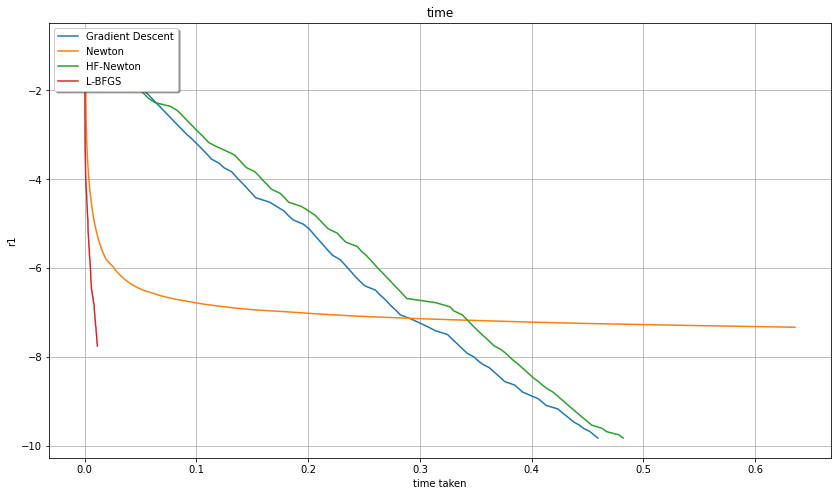

In [33]:
f = Oracle(X, y)
data = {
    "Wulf": None,
}
plot(f, plot_data, [gradient_descent, newton, hfnewton, lbfgs_optimize], data)

#### Зпустим L-BFGS с разными параметрами history-size и сравним скорость, точноть сходимости на примере датасета a1a.

In [59]:
print('Optimal value for dataset a1a:       0.2978754392048716')
print()
print('--------------------------------------------L-BFGS results:--------------------------------------------')
print()
print('history size = 1:   function value:  0.29858603158910224 Oracle count: 492 Time:  0.8783371448516846')
print('history size = 4:   function value:  0.29827513025861935 Oracle count: 490 Time:  0.3685770034790039')
print('history size = 10:  function value:  0.2979916110563088  Oracle count: 488 Time:  0.5551111698150635')
print('history size = 25:  function value:  0.2979101078151698  Oracle count: 502 Time:  0.5765268802642822')
print('history size = 50:  function value:  0.29787940119606426 Oracle count: 475 Time:  0.5616457462310791')
print('history size = 70:  function value:  0.29787795616850127 Oracle count: 428 Time:  0.5682392120361328')
print('history size = 100: function value:  0.29787925708239094 Oracle count: 404 Time:  0.5213019847869873')

Optimal value for dataset a1a:       0.2978754392048716

--------------------------------------------L-BFGS results:--------------------------------------------

history size = 1:   function value:  0.29858603158910224 Oracle count: 492 Time:  0.8783371448516846
history size = 4:   function value:  0.29827513025861935 Oracle count: 490 Time:  0.3685770034790039
history size = 10:  function value:  0.2979916110563088  Oracle count: 488 Time:  0.5551111698150635
history size = 25:  function value:  0.2979101078151698  Oracle count: 502 Time:  0.5765268802642822
history size = 50:  function value:  0.29787940119606426 Oracle count: 475 Time:  0.5616457462310791
history size = 70:  function value:  0.29787795616850127 Oracle count: 428 Time:  0.5682392120361328
history size = 100: function value:  0.29787925708239094 Oracle count: 404 Time:  0.5213019847869873


Выводы: 
- C увеличением параметра history-size прослеживается динамика снижения числа обращения к ораклу и времени работы метода.
- Точность повышается с ростом параметра: при history size = 1 получили точнось 1e-2, при history size = 100 1e-6.